In [1]:
import os
from defillama2 import DefiLlama
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../'
helper_dir = os.path.join(base_dir, 'helper')
png_dir = os.path.join(base_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

# load helper file
%run {helper_dir}/plot.py

In [3]:
def plot_tvl_apy(df, tvl_col='tvlUsd', apy_col='apy', title=None):
    # plot TVL and APY over time to see their relationships. 
    
    # plot TVL on the left y-axis
    ax1 = df[tvl_col].plot()
    dollar_formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
    ax1.yaxis.set_major_formatter(dollar_formatter)
    for tl in ax1.get_yticklabels():
        tl.set_color('#008FD5')
    ax1.set_ylabel('TVL ($USD)', color='#008FD5')

    # plot APY on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(df.index, df[apy_col], color='#77AB43')
    ax2.yaxis.set_major_formatter(PercentFormatter(decimals=2))
    for tl in ax2.get_yticklabels():
        tl.set_color('#77AB43')
    ax2.set_ylabel('APY', color='#77AB43')

    plt.title(title)
    plt.tight_layout()

## Get current APY and TVL of the UniV3 WBTC-WETH pools

There are two major UniV3 WBTC-WETH pools:

- [0.3%  fee](https://info.uniswap.org/#/pools/0xcbcdf9626bc03e24f779434178a73a0b4bad62ed)
- [0.05% fee](https://info.uniswap.org/#/pools/0x4585fe77225b41b697c938b018e2ac67ac5a20c0)

In [4]:
obj = DefiLlama()

In [5]:
df = obj.get_pools_yields()

In [6]:
is_true = (
    df.chain.isin(['Ethereum']) &
    df.project.isin(['uniswap-v3']) &
    df.symbol.isin(['WBTC-WETH']) 
)
cols = ['chain', 'project', 'symbol', 'pool', 'tvlUsd', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,pool,tvlUsd,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
47,Ethereum,uniswap-v3,WBTC-WETH,c5599b3a-ea73-4017-a867-72eb971301d1,197012879,28.7793,24.9764,14.0219,0.4886,214,Down,87.0000
97,Ethereum,uniswap-v3,WBTC-WETH,d59a5728-d391-4989-86f6-a94e11e0eb3b,83027478,20.8489,6.1840,20.8977,0.7000,214,Down,83.0000
5282,Ethereum,uniswap-v3,WBTC-WETH,d12f85a6-6684-4b8e-82bd-f47d3a052ace,123843,11.1257,11.1257,6.5430,0.6490,214,Down,85.0000


Observations:

- DefiLlama returns 3 pools. Comparing their TVL with the numbers reported on Uniswap, we conclude the first row is the pool with 0.05% fee and the second row is the pool with 0.3% fee. We'll ignore the 3rd row.
- The 0.05%-fee-pool has a TVL less than half of the 0.3%-fee-pool.
- The 0.05%-fee-pool has a APY twice of the 0.3%-fee-pool. For the last 7 days, the APY of the 0.05%-fee-pool dropped by 1.7% whereas the APY of the 0.3%-fee-pool increased by 1.2%. DefiLlama predicts the APY of the 0.05%-fee-pool will continue to drop and the APY of the 0.3%-fee-pool will remain steady or continue to rise with strong probabilities. 
- Historically, over 212 days, the average APY for the 0.05%-fee-pool is 20.87% with a standard deviation of 0.7%, and the average APY for the 0.3%-fee-pool is 13.78% with a standard deviation of 0.48%.

## Get historical APY and TVL of the UniV3 WBTC-WETH pools

In [7]:
pool_005_id = 'd59a5728-d391-4989-86f6-a94e11e0eb3b'
pool_03_id  = 'c5599b3a-ea73-4017-a867-72eb971301d1'

In [8]:
df005 = obj.get_pool_hist_apy(pool_005_id).loc[:,['tvlUsd', 'apy']]
df03  = obj.get_pool_hist_apy(pool_03_id).loc[:,['tvlUsd', 'apy']]

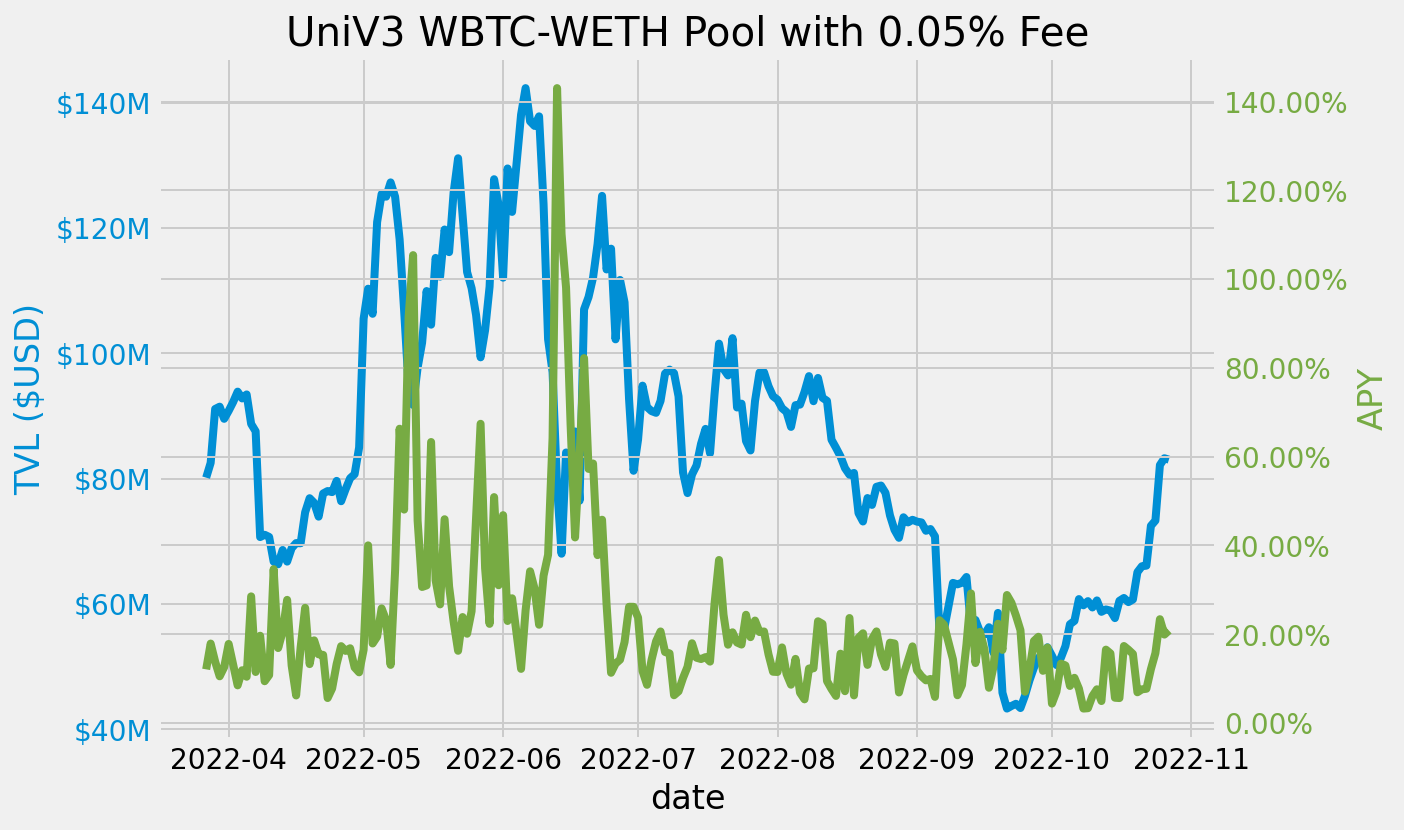

In [9]:
plot_tvl_apy(df005, title='UniV3 WBTC-WETH Pool with 0.05% Fee')
plt.savefig(os.path.join(png_dir, 'UniV3 WBTC-WETH Pool with 0.05% Fee.png'), dpi=300)

The TVL of the 0.05%-fee-pool has been increasing since late September. I suspect the reason was that people saw the 0.05%-fee-pool was generating more fees per unit TVL than the 0.3%-fee-pool and decided to provide liquidity in the 0.05%-fee-pool. The climbing of the TVL hasn't crushed the yield yet. But as DeFiLlama predcited, there is a high probability the TVL will keep going up and the yield will fall. 

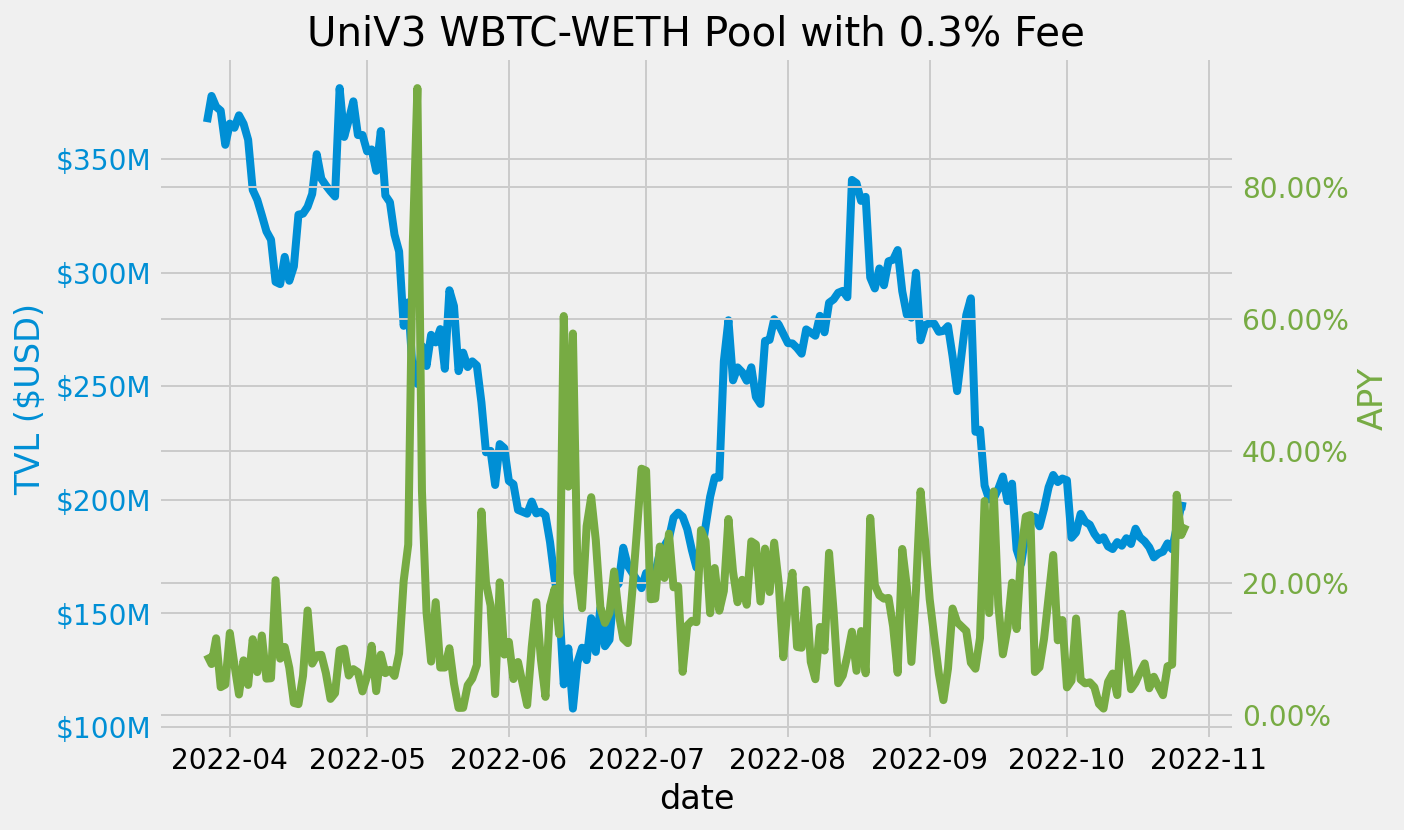

In [10]:
plot_tvl_apy(df03, title='UniV3 WBTC-WETH Pool with 0.3% Fee')
plt.savefig(os.path.join(png_dir, 'UniV3 WBTC-WETH Pool with 0.3% Fee.png'), dpi=300)

The TVL of the 0.3%-fee-pool had a big drop in September. It has stablized with a slight downward trend since the beginning of October.
Its yield has been trending down since mid September. DeFiLlama predicts its yield will NOT drop further with a high probability. 

In [11]:
# how many days in the past the 0.3%-fee-pool has APY > the 0.05%-fee-pool?
dat = pd.merge(df005, df03, left_index=True, right_index=True)
dat.columns = ['TVL005', 'APY005', 'TVL03', 'APY03']
(dat.APY005 > dat.APY03).sum()

150

In [12]:
(dat.APY005 > dat.APY03).sum() / len(dat)

0.704225352112676